This kernel was inspired by [this](https://www.pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/) tutorial.

The task is simple: we need to train ANN that will be classify food and non_food pictures.

To achieve this goal there will be next steps:
* Load pretrained ResNet50 without fully connected layers and use it as feature extractor
* Preapare images, extract features from them using pretrained ANN and store these features in numpy arrays
* Build small FC ANN and train it on these features

Let's start.

In [21]:
# Loading all necessary libraries and modules
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

In [22]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model = ResNet50(weights = 'imagenet', include_top = False)

I want to look how extracted features looks like, so I'll load one images and visualize it:

In [24]:
# Read image
orig = cv.imread('../../Datasets/ICDAR13/Train/100.jpg')
orig = cv.cvtColor(orig, cv.COLOR_BGR2RGB)
image = cv.resize(orig, (224, 224)).reshape(-1, 224, 224, 3)
image = preprocess_input(image)
features = model.predict(image)

features.shape

(1, 7, 7, 2048)

Now "features" array contains 2048 feature maps wits 7x7 size.

I want to plot random 9 features as example:

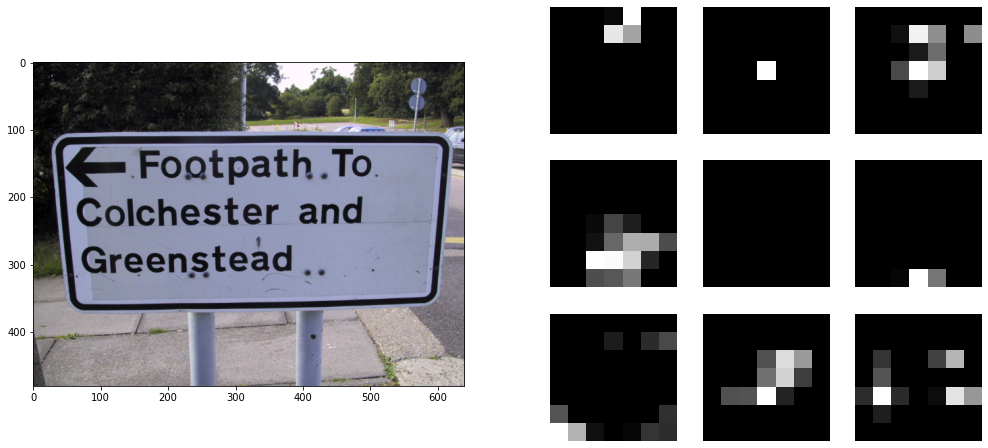

In [25]:
n_features = features.shape[-1]

fig = plt.figure(figsize = (17, 8))
gs = gridspec.GridSpec(1, 2, figure = fig)
sub_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(orig)

for i in range(3):
    for j in range(3):
        ax2 = fig.add_subplot(sub_gs[i, j])
        plt.axis('off')        
        plt.imshow(features[0, :, :, np.random.randint(n_features)], cmap = 'gray')  

On next step I want to prepare data for training and evaluation.

In [34]:
dataset_path = '../../Datasets/ICDAR13/'
sets = ['Train','Val','Test']

train_X, train_Y = ([], [])
val_X, val_Y = ([], [])
test_X, test_Y = ([], [])

data = [(train_X, train_Y), (val_X, val_Y), (test_X, test_Y)]

for s, d in (zip(sets, data)):
    path_to_images = os.path.join(dataset_path, s)
    for img in os.listdir(path_to_images):
        try:
            if img[-3:] == 'jpg':
                image_path = os.path.join(path_to_images, img)

                image = cv.imread(image_path)
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, (224, 224)).reshape(-1, 224, 224, 3)
                image = preprocess_input(image)

                features = model.predict(image).reshape(100352) # 7*7*2048 = 100352 nodes flattening

                d[0].append(features)
        except:
            pass

In [39]:
os.listdir(dataset_path)
len(data[1][0])

72

In [ ]:
# Shuffle data in each split
random_state = 666
train_X, train_Y = shuffle(train_X, train_Y, random_state = random_state)
val_X, val_Y = shuffle(val_X, val_Y, random_state = random_state)
eval_X, eval_Y = shuffle(eval_X, eval_Y, random_state = random_state)

In [ ]:
# Convert data to numpy arrays
train_X = np.array(train_X)
train_Y = np.array(train_Y)

val_X = np.array(val_X)
val_Y = np.array(val_Y)

eval_X = np.array(eval_X)
eval_Y = np.array(eval_Y)

In [ ]:
# Creating model
# Number of nodes were defined using rule: 
# take the square root of the previous number of nodes in the layer and then find the closest power of 2
# (Before FC layers in ResNet50 we have 7*7*2048 = 100352 nodes (after flatten layer), so if we take square root from
# this number we get 316.78 and closes power of 2 is 256, it's number of nodes in 1st FC layer in our network, 
# to define number of nodes in second layer we are getting swuare root from 256 = 16)
# Number of nodes in last layer = 1, because it's binary classification problem and our labels have only two values 0 and 1

model = Sequential()
model.add(Dense(256, input_shape = (100352,), activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(16, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(1, activation = 'sigmoid'))

# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(train_X, train_Y, batch_size = 64, epochs = 10, validation_data = [val_X, val_Y], callbacks = [checkpoint])

In [ ]:
# Plot losses and accuracies
history = model.history.history

fig = plt.figure(figsize = (8, 5))
plt.plot(history['accuracy'], label = 'acc')
plt.plot(history['val_accuracy'], label = 'val_acc')
plt.plot(history['loss'], label = 'acc')
plt.plot(history['val_loss'], label = 'acc')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Loading best model and evaluate it
# Here I want to compare keras.evaluate and sklearn.accuracy_score methods, just for curiosity
model.load_weights('best_model.hdf5')
model.evaluate(eval_X, eval_Y)

In [ ]:
# Making predictions using evaluation dataset
preds = model.predict(eval_X)

# If our prediction more than 0.5 - we round it to 1, else to 0
preds = [1 if i > 0.5 else 0 for i in preds]

# Calculating accuracy score
accuracy = accuracy_score(eval_Y, preds)
print(f'Accuracy: {round(accuracy * 100, 4)}%')

# Plotting confusion matrix
l = ['non_food', 'food']
confusion = confusion_matrix(eval_Y, preds)
sns.heatmap(confusion, square = True, fmt = 'd', xticklabels = l, yticklabels = l, annot = True)

Well, feature extraction with pretrained ANN like ResNet50 is a very powerfull technique - using it, instead of building new CNN for this task, we managed to train shallow and fast FC ANN that can classify food and non_food with about 99% accuracy.